# Analyze the tree-guided MTL results on the EndoMT data produced in Frankfurt (data imputed)

The purpose of this analysis is to study the role of transcription factors (TFs) measured in vitro (TEPIC- TF binding affinities) in deriving the gene expession in single cells of two  cell types. We expect the statistical model to select distinct sets of TFs for each cell type.

## Data
The data to be used for training the tree-guided MTL model:

### Features
Promoter: The TF binding affinities measured in peaks obtained by DNase-seq of HUVEC cells (mapped against genome hg38)

### Responses
   * The response **matrix** here is essentially the gene expression matrix for the EndoMT cells (hg38).
   * scImpute was run on the entire gene expression with the k parameter (indicating the num of cell types) to 2 to address the drop-out issue.
   * The imputed read counts are then converted to TPM values using my compute_TPM.R script.

## Filtering
### Based on gene expression variance
The genes showing small variance in their expression across the single cells are removed from the data.
### Based on TF expression
The TFs that their corresponding genes are not expressed in more than 90% of the cells are removed as well.

## Model fitting
* Partitioned 60% of the data for training and 40% for test
* Data is normalized with zero mean and unit variance
* 5-fold CV is used to select the model with best average CV error.
* 21 lambda values are explored during the CV prodecure.
* **Maximum number of iterations is now increased to 1000**

The fitted model together with the partitioned data are stored in an RData object that can be loaded.

## Load the model trained on imputed data

In [1]:
load("../../scMTL_EndoMT_imputed_epigenetic_TGGLasso.RData")

## Log-transfer and normalize the partitioned data
The stored partitioned data in the above RData object is in the original space. In order to proceed with the downstream analysis, it's easier to normalize them in the same way they were done before model fitting.

In [2]:
x.train <- scale(log2(1 + partition$train$x))
y.train <- scale(log2(1 + partition$train$y))


x.test <- scale(log2(1 + partition$test$x), center= colMeans(log2(1 + partition$train$x)),
                scale= apply(log2(1 + partition$train$x), 2, FUN= sd))
y.test <- scale(log2(1 + partition$test$y), center= colMeans(log2(1 + partition$train$y)),
                scale= apply(log2(1 + partition$train$y), 2, FUN= sd))

## Train and test dimenstion

In [3]:
print("train:")
print(dim(x.train))
print("test:")
print(dim(x.test))

[1] "train:"
[1] 2583  727
[1] "test:"
[1] 1722  727


## Cell names

In [4]:
head(colnames(y.train))

[1] "AAACCTGGTTACCAGT.1" "AAACCTGTCCCAGGTG.1" "AAACCTGTCTCAACTT.1"
[4] "AAACGGGGTGACCAAG.1" "AAAGATGCATTCACTT.1" "AAAGATGTCGTACCGG.1"

## PCA applied on training and test features
Unfortunately this part does not work for this dataset, since we have more features than samples (more TFs than genes)

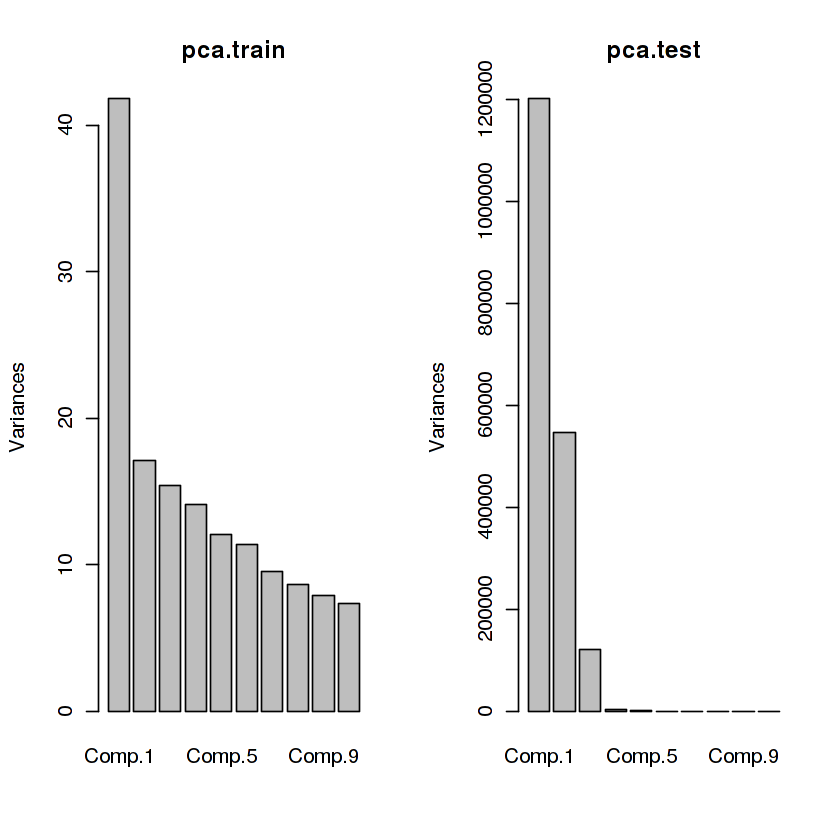

In [5]:
doPCA <- TRUE
if(doPCA){
    pca.train <- princomp(x.train)
    pca.test <- princomp(x.test)
    par(mfrow= c(1, 2))
    plot(pca.train)
    plot(pca.test)
}

## Compute the predictions on training and test data

In [6]:
pred.train <- cbind(1, x.train) %*% rbind(TGL.model$intercept, TGL.model$B)
pred.test <- cbind(1, x.test) %*% rbind(TGL.model$intercept, TGL.model$B)

### Plot the scatter plots for some random cells (training data)

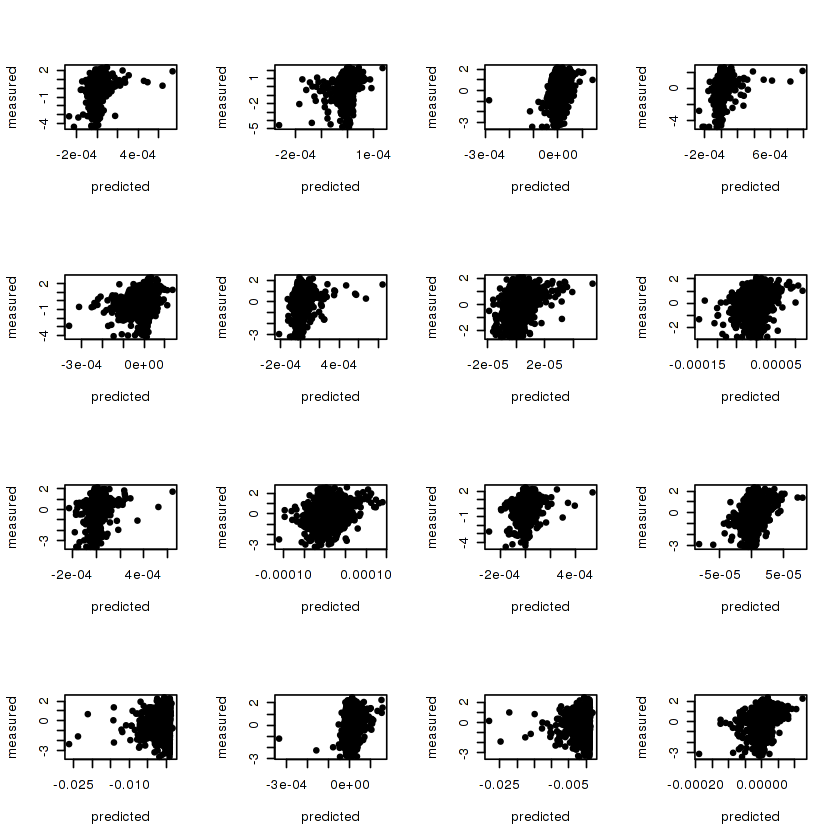

In [7]:
n <- 16
par(mfrow = c(sqrt(n), sqrt(n)))

random.idx <- sample(ncol(pred.train))[seq(n)]
for(i in seq(n))
    plot(pred.train[, random.idx[i]], y.train[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

### Plot the scatter plots for some random cells (test data)

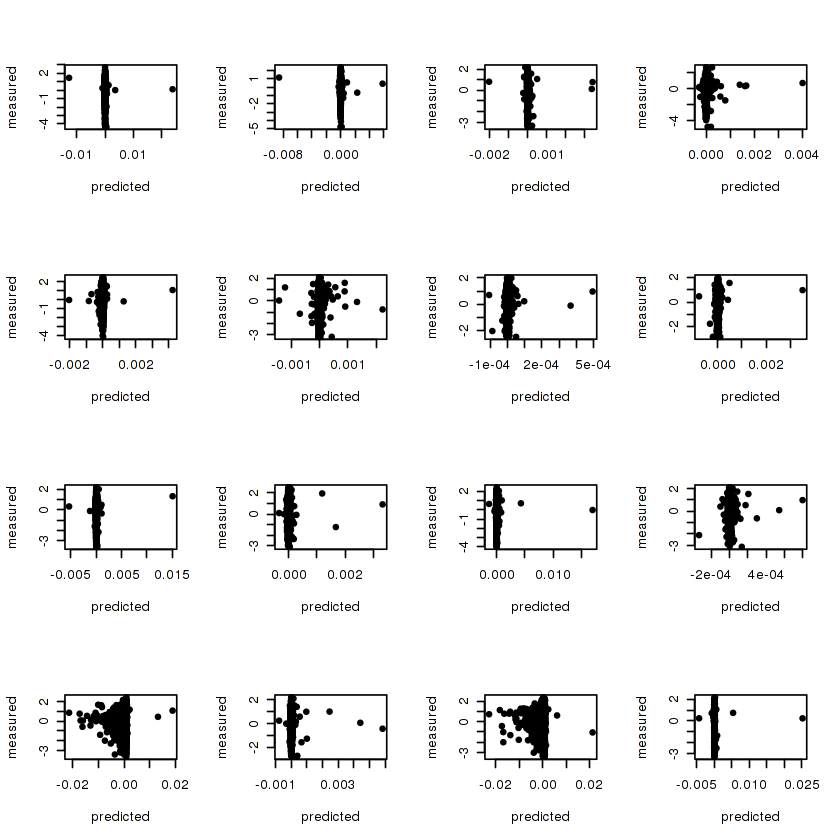

In [8]:
#n <- 25
par(mfrow = c(sqrt(n), sqrt(n)))

#random.idx <- sample(ncol(pred.test))[seq(n)]
for(i in seq(n))
    plot(pred.test[, random.idx[i]], y.test[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

## Compute the correlations between predicted and actual measurements of gene expression

In [9]:
options(warn= -1)
# Train
## Method= Pearson
cors.train.p <- sapply(seq(ncol(pred.train)), function(i)
    cor(pred.train[, i], y.train[, i], method= "pearson"))

## Method= Spearman
cors.train.s <- sapply(seq(ncol(pred.train)), function(i)
    cor(pred.train[, i], y.train[, i], method= "spearman"))
                      
# Test
## Method= Pearson
cors.test.p <- sapply(seq(ncol(pred.test)), function(i)
    cor(pred.test[, i], y.test[, i], method= "pearson"))

## Method= Spearman
cors.test.s <- sapply(seq(ncol(pred.test)), function(i)
    cor(pred.test[, i], y.test[, i], method= "spearman"))

## Plot the prediction correlations for each cell colored according to the cell type

In [10]:
cell.types <- sapply(seq(ncol(y.train)), function(i) strsplit(colnames(y.train)[i], "\\.")[[1]][2])
print(range(cell.types))

[1] "1" "2"


### HLC: red, PHH: blue

In [11]:
cols <- rep("red", ncol(y.train))
cols[which(cell.types == "2")] <- "blue" # differentiated

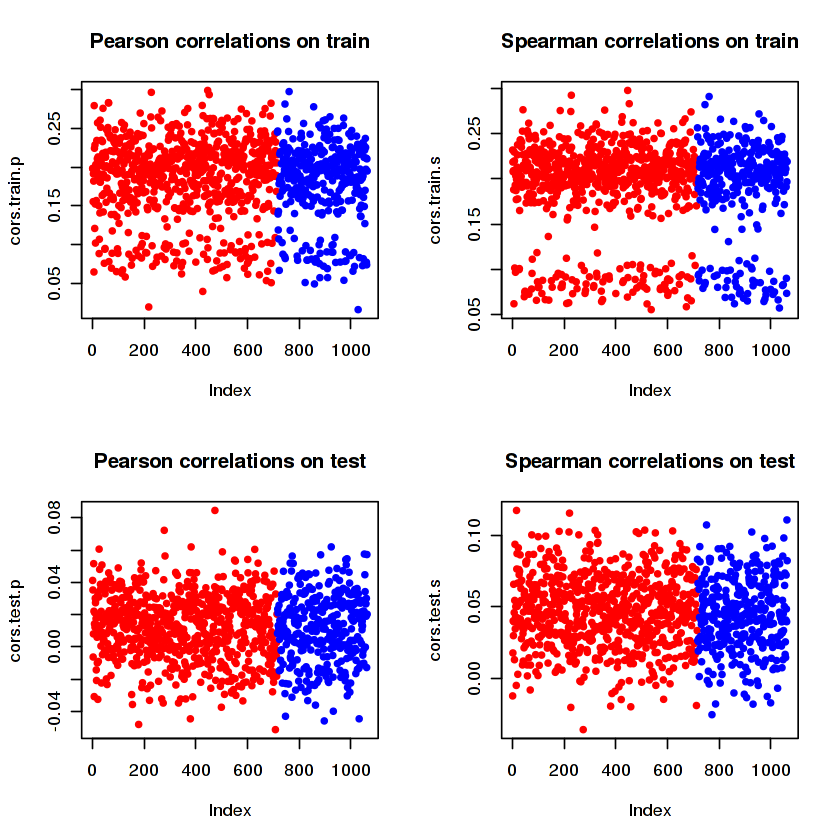

In [12]:
par(mfrow = c(2, 2))

plot(cors.train.p, main= "Pearson correlations on train", col= cols, pch= 20)
plot(cors.train.s, main= "Spearman correlations on train", col= cols, pch= 20)
plot(cors.test.p, main= "Pearson correlations on test", col= cols, pch= 20)
plot(cors.test.s, main= "Spearman correlations on test", col= cols, pch= 20)

## Plot the coefficients obtained from the model

In [13]:
## Load the heatmap library
library(pheatmap)

## Make the column annotation dataframe for the pheatmap function
ann_col <- data.frame(cell_types= cell.types)
rownames(ann_col) <- colnames(y.train)
colnames(TGL.model$B) <- colnames(y.train)

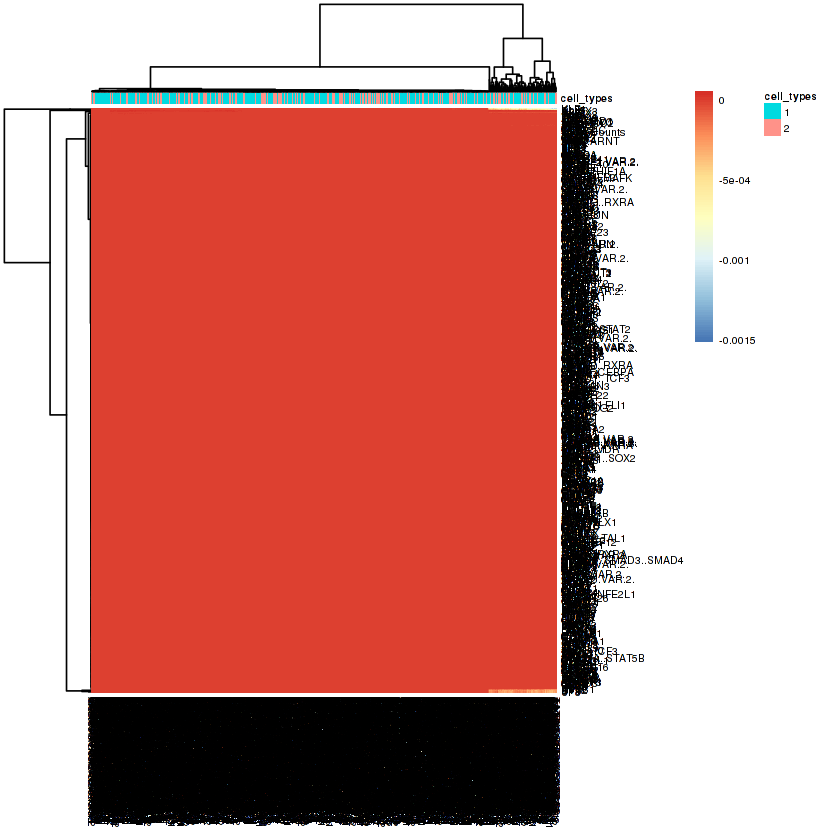

In [14]:
pheatmap(TGL.model$B, annotation_col= ann_col, fontsize= 6)

## Selecting top TFs

In [15]:
top_TFs <- which(rowSums(abs(TGL.model$B)) > .1)
length(top_TFs)

[1] 2

In [16]:
## Make the column annotation dataframe for the pheatmap function
ann_col <- data.frame(cell_types= cell.types)
rownames(ann_col) <- colnames(y.train)
colnames(TGL.model$B) <- colnames(y.train)

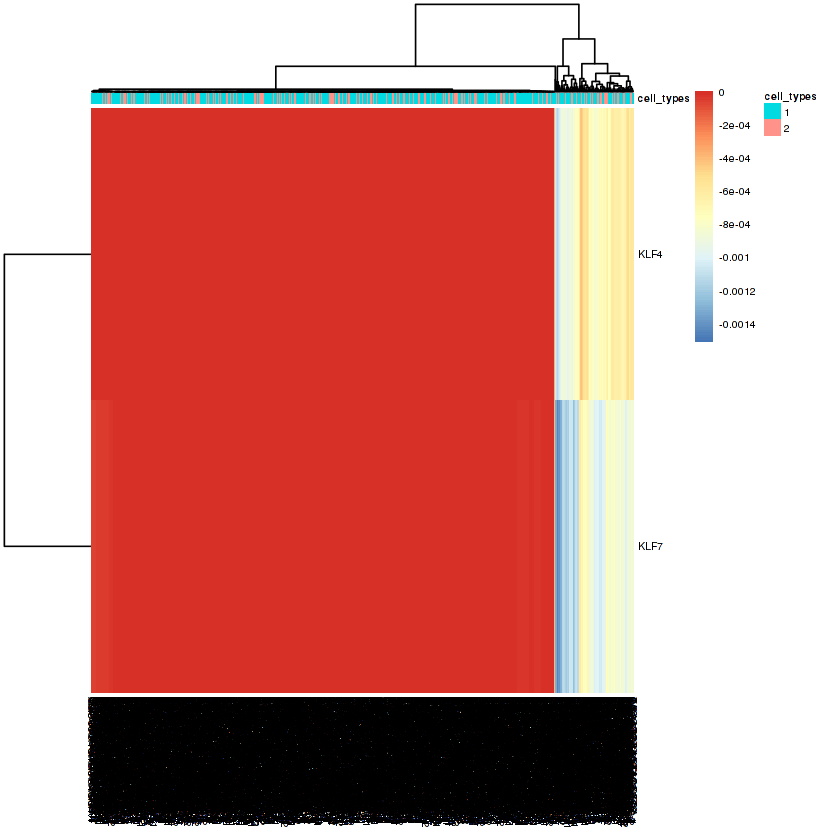

In [17]:
pheatmap(TGL.model$B[top_TFs, ], annotation_col= ann_col, fontsize= 6)

### Printing top TFs

In [18]:
print(rownames(TGL.model$B[top_TFs, ]))

[1] "KLF4" "KLF7"


# Conclusion
* The models isn't well-trained, even increasing the number of iterations for the stochastic gradient descent step didn't result in a more accurate model
* Florian mentioned to me that he also didn't get very good results from the HUVEC DNase-seq data from ENCODE. So, it might as well be the low quality data that prevents the model from accurately predicting the response. Probably extracting the endothelial cells from the ubmilical vein isn't that easy, and the sample contains mixed cells of other tissues.
* Even though the model is poorly trained and one can't really trust the coefficients assigned to the features, I still wanted to know what KLF4 is known for. According to genecards, the KLF4 TF is known to maintain the embryonic stem cells into their undifferentiated state. It is involved in differentiation of the epithelial cells. Meaning, I couldn't find any relevance to the regulation of these endothelial cells we're interested in.